## 0.1. Import

In [ ]:
#import os
import optuna
import shap
import pickle

import pandas             as pd
import matplotlib.pyplot  as plt
import numpy              as np
import xgboost            as xgb


from sklearn.preprocessing    import RobustScaler, MinMaxScaler
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import StratifiedKFold
from category_encoders        import CountEncoder


from sksurv.util              import Surv
from sksurv.metrics           import concordance_index_censored, integrated_brier_score

from lifelines                import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.utils          import qth_survival_times


from lifelines                import (
    WeibullFitter,
    LogNormalFitter,
    LogLogisticFitter,
    KaplanMeierFitter
)




## 0.2 Helper Function

In [26]:
def split_proportional_times(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):


    if 'date_ini' not in df.columns:
        raise ValueError("O DataFrame deve conter a coluna 'date_ini' (data).")

        # Ordenar o DataFrame pelo 'date_ini'
    df = df.sort_values(by='date_ini')

    # 1. Definir o número total de observações
    total_linhas = len(df)

    # 2. Calcular os tamanhos dos conjuntos de dados
    num_treino = int(total_linhas * train_ratio)
    num_validacao = int(total_linhas * val_ratio)
    # O restante vai para o Teste

    # 3. Encontrar as Datas de Corte (Cutoff Dates)
    # O corte deve ser baseado na posição da linha no DataFrame ORDENADO

    # Corte 1: Fim do Treino (início da Validação)
    data_corte_1 = df.iloc[num_treino]['date_ini']

    # Corte 2: Fim da Validação (início do Teste)
    # Deve começar a contar a partir do final do treino
    data_corte_2 = df.iloc[num_treino + num_validacao]['date_ini']

    # 4. Dividir o DataFrame

    # Treino: Todas as observações até o dia anterior à data_corte_1
    df_treino = df[df['date_ini'] < data_corte_1].copy()

    # Validação: Observações a partir da data_corte_1 até o dia anterior à data_corte_2
    df_validacao = df[
        (df['date_ini'] >= data_corte_1) &
        (df['date_ini'] < data_corte_2)
    ].copy()

    # Teste: Observações a partir da data_corte_2
    df_teste = df[df['date_ini'] >= data_corte_2].copy()

    # Ajuste Final para garantir que o Treino termine no último dia antes da Validação
    # Isso pode ser necessário se houver múltiplos unique_ids no dia do corte
    data_max_treino = df_treino['date_ini'].max()
    df_treino = df[df['date_ini'] <= data_max_treino].copy()
    df_validacao = df[(df['date_ini'] > data_max_treino) & (df['date_ini'] < data_corte_2)].copy()
    df_teste = df[df['date_ini'] >= data_corte_2].copy()

    # 5. Imprimir as estatísticas
    print("--- Divisão Temporal Proporcional (Por Linhas) ---")
    print(f"Total de Linhas: {total_linhas}")
    print(f"Treino: {len(df_treino)} linhas ({len(df_treino)/total_linhas:.2%}) | Data Fim: {df_treino['date_ini'].max()}")
    print(f"Validação: {len(df_validacao)} linhas ({len(df_validacao)/total_linhas:.2%}) | Data Fim: {df_validacao['date_ini'].max()}")
    print(f"Teste: {len(df_teste)} linhas ({len(df_teste)/total_linhas:.2%}) | Data Início: {df_teste['date_ini'].min()}")

    return df_treino, df_validacao, df_teste



def make_surv_object(df, time_col="days", event_col='is_churn'):
    return Surv.from_dataframe(event_col, time_col, df)


def make_y_xgb(df,time_col="days",event_col="is_churn"):
    y_xgb = df[time_col].copy()
    y_xgb[df[event_col] == 0] *= -1
    return y_xgb

def make_y_aft(df, time_col, event_col):
    y = df[time_col].values.copy()


    y[df[event_col] == 0] *= -1

    return y


def train_xgb_survival(X_train,y_train_xgb,params,num_boost_round=500):
    
    dtrain = xgb.DMatrix(X_train, label=y_train_xgb)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round
    )

    return model


def metrics(model, x_val, y_val_surv):
    
    dval = xgb.DMatrix(x_val)
    risk_scores = model.predict(dval)

    c_index = concordance_index_censored(y_val_surv["is_churn"], y_val_surv["days"],risk_scores)[0]

    return c_index


def make_aft_bounds(df):
    max_time = df["days"].max() * 10  
    lower = df["days"].values.astype(float)
    upper = np.where(df["is_churn"]==1, df["days"].values.astype(float), max_time)
    return lower, upper


def simular_reversao(data, percentuais):
    total_perda_potencial = data['actual_paid'].sum()
    resultados = []
    
    for p in percentuais:
       
        n_clientes = int(len(data) * (p / 100))
        clientes_salvos = data.head(n_clientes)
        
        receita_recuperada = clientes_salvos['actual_paid'].sum()
        percentual_valor_salvo = (receita_recuperada / total_perda_potencial) * 100

        Recuperado_em_3_meses = receita_recuperada * 3
        Recuperado_em_6_meses = receita_recuperada * 6
        Recuperado_em_12_meses = receita_recuperada * 12
        Recuperado_em_24_meses = receita_recuperada * 24
        
        resultados.append({
            'Cenário (Redução Churn %)': f"{p}%",
            'Clientes Atendidos': n_clientes,
            'Valor Recuperado': receita_recuperada,
            '% do Valor Total Salvo': percentual_valor_salvo,
            'Rec_em_3_meses': Recuperado_em_3_meses,
            'Rec_em_6_meses': Recuperado_em_6_meses,
            'Rec_em_12_meses': Recuperado_em_12_meses,
            'Rec_em_24_meses': Recuperado_em_24_meses
        })
    
    return pd.DataFrame(resultados)


# def retention_priority(risk, value, time, p90_value, lam=np.log(2)):
#     # 1. Probabilidade de churn
#     prob = 1 / (1 + np.exp(-risk))
    
#     # 2. Valor normalizado
#     v_norm = np.minimum(value / p90_value, 1)
    
#     # 3. Urgência temporal
#     urgency = np.exp(-lam * time)
    
#     # 4. Score final
#     return prob * v_norm * urgency





# def balanced_sample_by_year(df, label="is_churn", year_col="year", random_state=42):
#     samples = []

#     for year, g in df.groupby(year_col):
#         churn = g[g[label] == 1]
#         non_churn = g[g[label] == 0]

#         n = min(len(churn), len(non_churn))

#         # se um ano não tiver churn suficiente, pula
#         if n == 0:
#             continue

#         churn_s = churn.sample(n=n, random_state=random_state)
#         non_churn_s = non_churn.sample(n=n, random_state=random_state)

#         samples.append(pd.concat([churn_s, non_churn_s]))

#     return pd.concat(samples).sample(frac=1, random_state=random_state).reset_index(drop=True)

## 0.3.0 Fonte dos dados

Os dados foram obtidos no Kaggle no link da competição da empresa KKBox. Foram utilizadas as bases train_v2, members v3 e transactions. Tais bases podem ser obtidas no link:

https://www.kaggle.com/competitions/kkbox-churn-prediction-challenge/data?select=train_v2.csv.7z

## 0.3.1 Load data

In [ ]:
# base_path = os.getcwd()
# parent_path = os.path.dirname(base_path)
# file_path = os.path.join(parent_path,"data","")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = "/content/drive/MyDrive/Analise_sobrevivencia/"

In [28]:
dir_customer = pd.read_csv(file_path+"train_v2.csv")
dir_members = pd.read_csv(file_path+"members_v3.csv")
dir_transactions = pd.read_csv(file_path+"transactions.csv")


##  1.0. Description Data

### 1.1 Rename columns

In [5]:
print(dir_customer.columns)
print(dir_members.columns)
print(dir_transactions.columns)


Index(['msno', 'is_churn'], dtype='object')
Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time'],
      dtype='object')
Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')


### 1.2 Data Dimensions

In [6]:
print(dir_customer.shape)
print(dir_members.shape)
print(dir_transactions.shape)


(970960, 2)
(6769473, 6)
(21547746, 9)


### 1.3 Transaction consolidation

In [29]:
df_transactions = dir_transactions.groupby("msno").agg(payment_method = ("payment_method_id","max"),
                                    payments_pan_days = ("payment_plan_days","max"),
                                    plan_list_price = ("plan_list_price","max"),
                                    is_auto_renew = ("is_auto_renew","max"),
                                    actual_paid = ("actual_amount_paid","max"),
                                    expiration_assinatura = ("membership_expire_date","max")
                                    ).reset_index()

In [30]:
df_transactions.shape

(2363626, 7)

In [ ]:
#dir_transactions = 1

### 1.5. Data types

In [10]:
print(dir_customer.dtypes)



msno        object
is_churn     int64
dtype: object


In [11]:
print(dir_members.dtypes)



msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
dtype: object


In [12]:
print(df_transactions.dtypes)

msno                     object
payment_method            int64
payments_pan_days         int64
plan_list_price           int64
is_auto_renew             int64
actual_paid               int64
expiration_assinatura     int64
dtype: object


### 1.6 Null

In [13]:
dir_customer.isna().sum()

msno        0
is_churn    0
dtype: int64

In [14]:
dir_members.isna().sum()

msno                            0
city                            0
bd                              0
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

In [15]:
df_transactions.isna().sum()

msno                     0
payment_method           0
payments_pan_days        0
plan_list_price          0
is_auto_renew            0
actual_paid              0
expiration_assinatura    0
dtype: int64

### 1.7 Change dtypes

In [32]:
df_members = dir_members.copy()

In [33]:
df_members["date_ini"] = pd.to_datetime(df_members["registration_init_time"], format='%Y%m%d')
df_transactions["date_fim"] = pd.to_datetime(df_transactions["expiration_assinatura"], format='%Y%m%d')

In [34]:
df_members = df_members.drop(columns=["registration_init_time"])
df_transactions = df_transactions.drop(columns=["expiration_assinatura"])

### 1.8 Merge bases

In [35]:
df_raw = pd.merge(dir_customer,df_members, on="msno",how="left")
df_raw = pd.merge(df_raw,df_transactions, on="msno",how="left")
df_raw["year"] = df_raw["date_ini"].dt.year

### 1.9.1. Description Statistical

In [42]:
df_raw.isnull().sum()

msno                      0
is_churn                  0
city                 109993
bd                   109993
gender               582055
registered_via       109993
date_ini             109993
payment_method         2527
payments_pan_days      2527
plan_list_price        2527
is_auto_renew          2527
actual_paid            2527
date_fim               2527
dtype: int64

In [44]:
df_raw.isna().sum()

msno                      0
is_churn                  0
city                 109993
bd                   109993
gender               582055
registered_via       109993
date_ini             109993
payment_method         2527
payments_pan_days      2527
plan_list_price        2527
is_auto_renew          2527
actual_paid            2527
date_fim               2527
dtype: int64

### 1.9.2 Drop column

In [36]:
df_raw = df_raw.drop(columns=["gender","bd"])

### 1.9.3 Drop NA

In [37]:
df_raw = df_raw.dropna()

### 1.9.4 Table showing churn representation

In [31]:

fv = df_raw.loc[df_raw["is_churn"]==1,["year","is_churn"]].groupby("year").count()
rv = df_raw[["year","msno"]].groupby("year").count()
base_drescription = pd.merge(fv,rv,on="year",how="inner")
base_drescription["%_of_churn"]=(base_drescription["is_churn"]/base_drescription["msno"])*100
base_drescription["%_of_base_total"]=base_drescription["msno"]/base_drescription["msno"].sum()*100
base_drescription["%_of_total_accumulated_base"]=(base_drescription["msno"].cumsum()/base_drescription["msno"].sum())*100
base_drescription["total_line"]=base_drescription["msno"].sum()
base_drescription.rename(columns={"msno":"Total_number_of_lines"})

,is_churn,Total_number_of_lines,%_of_churn,%_of_base_total,%_of_total_accumulated_base,total_line
year,,,,,,
2004.0,732,8328,8.789625,0.969573,0.969573,858935
2005.0,1062,15613,6.802024,1.817716,2.787289,858935
2006.0,1461,18036,8.100466,2.099810,4.887099,858935
2007.0,2353,26135,9.003252,3.042722,7.929820,858935
2008.0,1767,17666,10.002264,2.056733,9.986553,858935
2009.0,1734,15715,11.034044,1.829591,11.816144,858935
2010.0,4483,38611,11.610681,4.495218,16.311362,858935
2011.0,5316,60662,8.763311,7.062467,23.373829,858935
2012.0,7120,74422,9.567064,8.664451,32.038280,858935


## 2.0 Feature Engineering

#### 2.1 Days column

In [38]:
df_raw["days"] = df_raw.apply(lambda x: (x["date_fim"]-x["date_ini"]).days if pd.notnull(x["date_fim"]) else pd.to_datetime('today').normalize()-x["date_ini"], axis = 1)

In [15]:
faltantes = pd.DataFrame({"Null":df_raw.isna().sum(),"%_null_of_base":(df_raw.isna().sum()/len(df_raw))*100,"total_lines":len(df_raw),"%_Churn_of_base":(df_raw[df_raw["is_churn"]==1].isna().sum()/len(df_raw))*100})
print(faltantes)

                   Null  %_null_of_base  total_lines  %_Churn_of_base
msno                  0             0.0       858935              0.0
is_churn              0             0.0       858935              0.0
city                  0             0.0       858935              0.0
registered_via        0             0.0       858935              0.0
date_ini              0             0.0       858935              0.0
payment_method        0             0.0       858935              0.0
payments_pan_days     0             0.0       858935              0.0
plan_list_price       0             0.0       858935              0.0
is_auto_renew         0             0.0       858935              0.0
actual_paid           0             0.0       858935              0.0
date_fim              0             0.0       858935              0.0
year                  0             0.0       858935              0.0
days                  0             0.0       858935              0.0


In [39]:
df_raw["days"] = df_raw["days"].astype("int64")

# 3.0 Sampling

**The database contains information from 2004 to 2017. Premise: Only data from 2013 onwards will be used due to the distortion that can occur when working with very old data for churn analysis.**

In [40]:
df_raw = df_raw[df_raw["year"]>=2013]

df_raw = df_raw.drop(columns="year")

# 4.0. EDA

In [18]:
df1 = df_raw.drop(columns=["date_ini","date_fim"], axis=1)
df1 = df1[df1["days"]>0]

In [19]:
df1.describe()

,is_churn,city,registered_via,payment_method,payments_pan_days,plan_list_price,is_auto_renew,actual_paid,days
count,583743.000000,583743.000000,583743.000000,583743.000000,583743.000000,583743.000000,583743.000000,583743.000000,583743.000000
mean,0.092971,4.613302,6.444882,39.511273,40.871329,177.450727,0.865259,177.423493,657.432038
std,0.290392,5.948792,1.869036,2.964684,52.912959,231.250782,0.341447,233.292780,437.614068
min,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,1.000000,7.000000,39.000000,30.000000,99.000000,1.000000,99.000000,303.000000
50%,0.000000,1.000000,7.000000,41.000000,30.000000,149.000000,1.000000,149.000000,543.000000
75%,0.000000,6.000000,7.000000,41.000000,30.000000,149.000000,1.000000,149.000000,1059.000000
max,1.000000,22.000000,13.000000,41.000000,450.000000,2000.000000,1.000000,2000.000000,1550.000000


### 4.1 Taxa de censura

In [22]:
censoring_rate = 1 - df1["is_churn"].mean()
print(f"Taxa de censura global: {censoring_rate:.2%}")

Taxa de censura global: 90.70%


In [23]:
df1["is_churn"].value_counts(normalize=True)

is_churn
0    0.907029
1    0.092971
Name: proportion, dtype: float64

### 4.2 Churn rate among groups

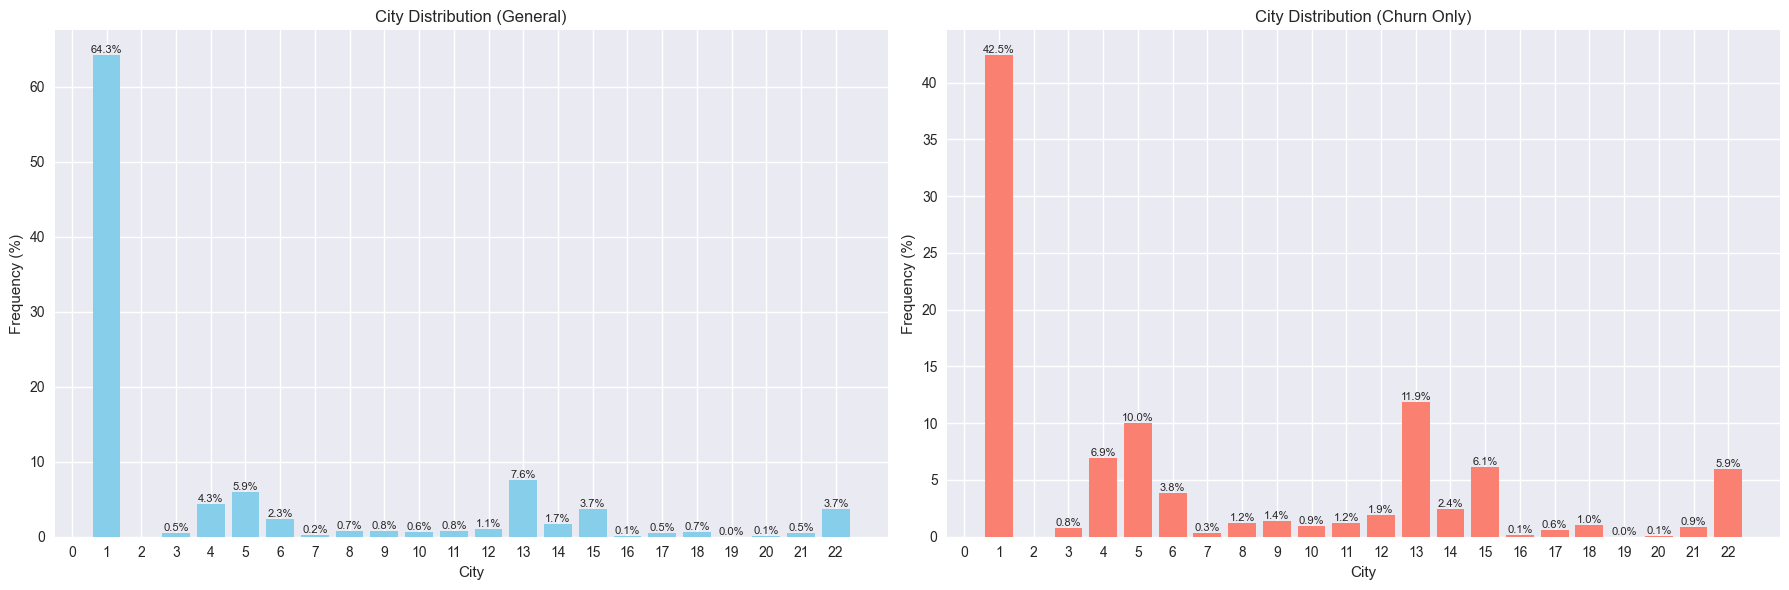

In [24]:
counts = df1["city"].value_counts(normalize=True).sort_values(ascending=False)*100
counts_churn = df1[df1["is_churn"]==1]["city"].value_counts(normalize=True).sort_values(ascending=False)*100

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
bars1 = ax1.bar(counts.index, counts.values, color='skyblue')
ax1.set_title("City Distribution (General)")
ax1.set_xlabel("City")
ax1.set_ylabel("Frequency (%)")
ax1.set_xticks(np.arange(0, 23, step=1))

for bar in bars1:
    y = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=8)

bars2 = ax2.bar(counts_churn.index, counts_churn.values, color='salmon')
ax2.set_title("City Distribution (Churn Only)")
ax2.set_xlabel("City")
ax2.set_ylabel("Frequency (%)")
ax2.set_xticks(np.arange(0, 23, step=1))

for bar in bars2:
    y = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

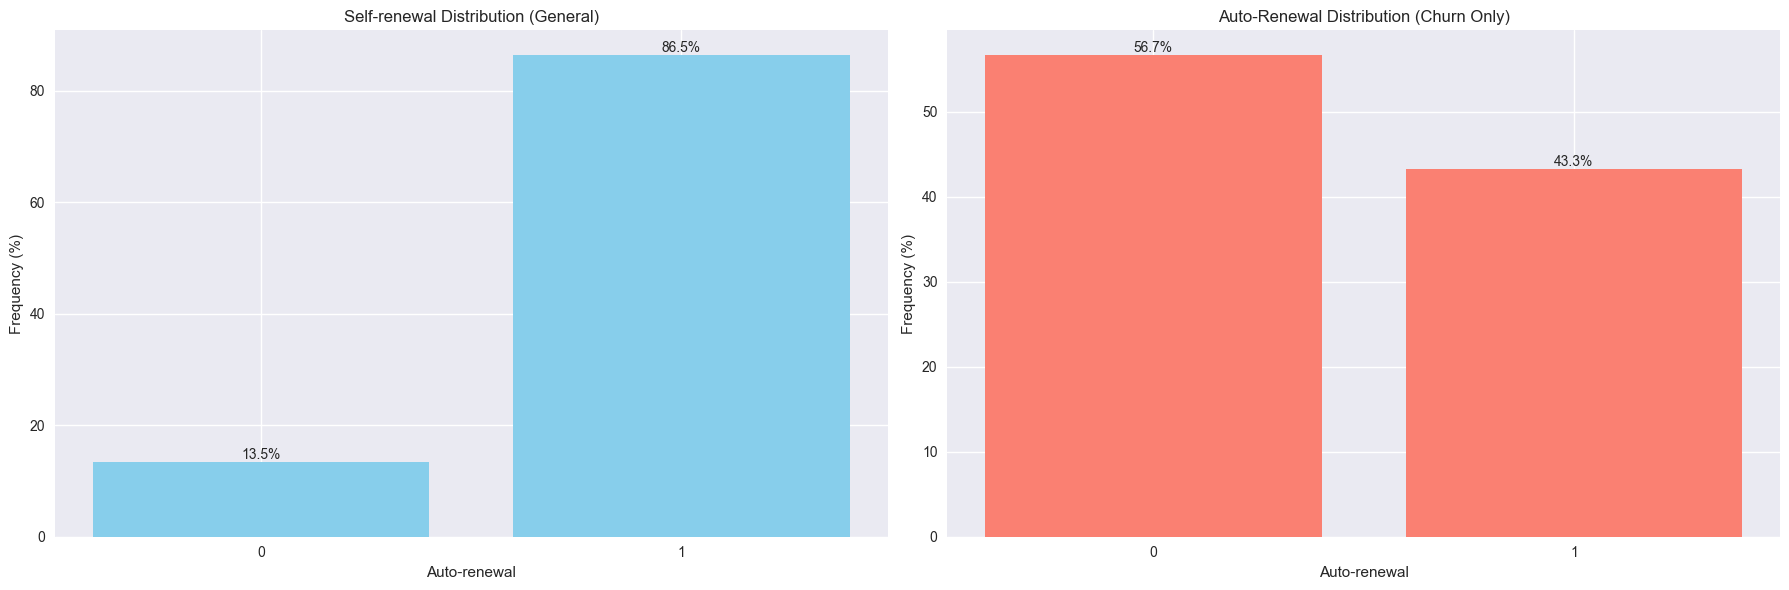

In [58]:
counts = df1["is_auto_renew"].value_counts(normalize=True).sort_values(ascending=False)*100
counts_churn = df1[df1["is_churn"]==1]["is_auto_renew"].value_counts(normalize=True).sort_values(ascending=False)*100

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
bars1 = ax1.bar(counts.index, counts.values, color='skyblue')
ax1.set_title("Self-renewal Distribution (General)")
ax1.set_xlabel("Auto-renewal")
ax1.set_ylabel("Frequency (%)")
ax1.set_xticks(np.arange(0, 2, step=1))

for bar in bars1:
    y = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

bars2 = ax2.bar(counts_churn.index, counts_churn.values, color='salmon')
ax2.set_title("Auto-Renewal Distribution (Churn Only)")
ax2.set_xlabel("Auto-renewal")
ax2.set_ylabel("Frequency (%)")
ax2.set_xticks(np.arange(0, 2, step=1))

for bar in bars2:
    y = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

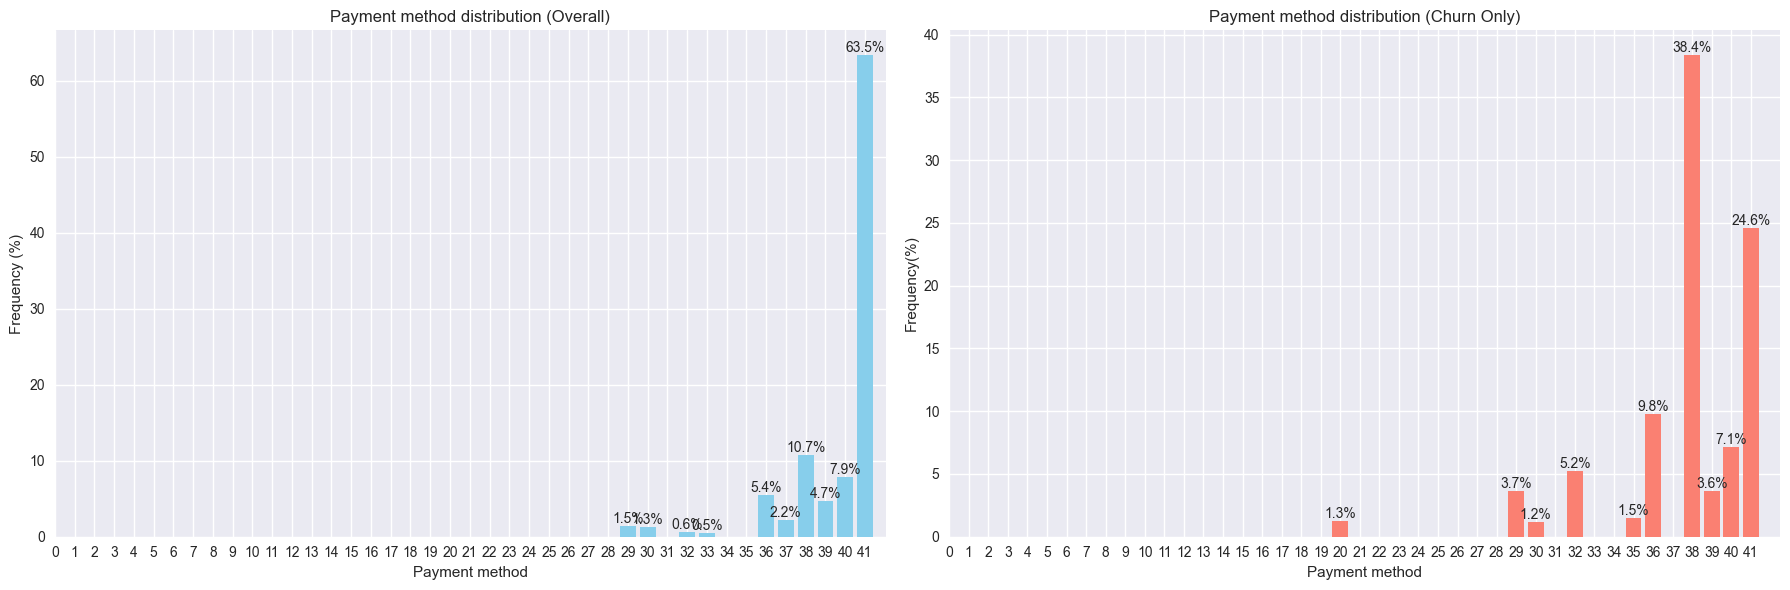

In [59]:
counts = (df1["payment_method"].value_counts(normalize=True).sort_values(ascending=False) * 100).head(10)
counts_churn = (df1[df1["is_churn"]==1]["payment_method"].value_counts(normalize=True).sort_values(ascending=False)*100).head(10)

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
bars1 = ax1.bar(counts.index, counts.values, color='skyblue')
ax1.set_title("Payment method distribution (Overall)")
ax1.set_xlabel("Payment method")
ax1.set_ylabel("Frequency (%)")
ax1.set_xticks(np.arange(0, 42, step=1))

for bar in bars1:
    y = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

bars2 = ax2.bar(counts_churn.index, counts_churn.values, color='salmon')
ax2.set_title("Payment method distribution (Churn Only)")
ax2.set_xlabel("Payment method")
ax2.set_ylabel("Frequency(%)")
ax2.set_xticks(np.arange(0, 42, step=1))

for bar in bars2:
    y = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

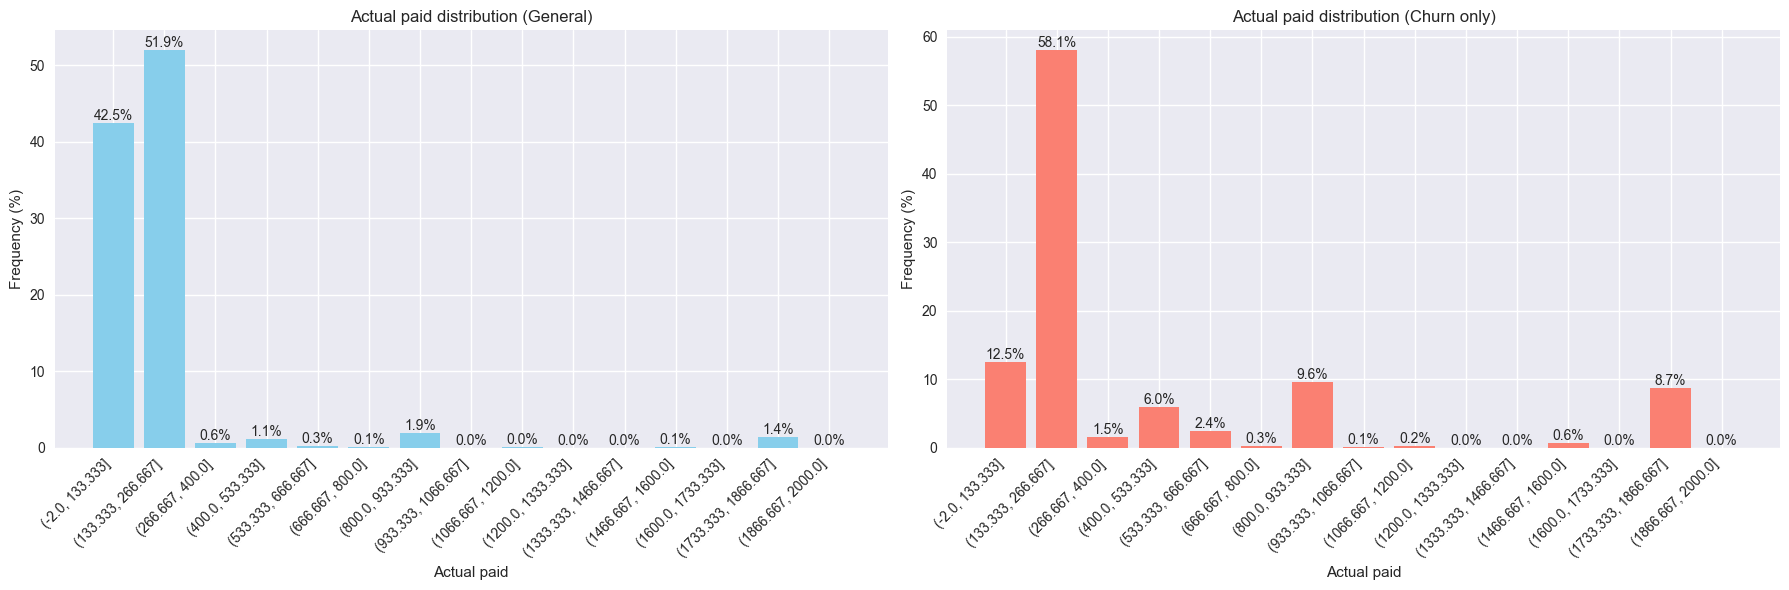

In [82]:
counts = (pd.cut(df1["actual_paid"], bins=15)
          .value_counts(normalize=True)
          .sort_index() * 100)

counts_churn = (pd.cut(df1[df1["is_churn"]==1]["actual_paid"], bins=15)
                .value_counts(normalize=True)
                .sort_index() * 100)

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
bars1 = ax1.bar(counts.index.astype(str), counts.values, color='skyblue')
ax1.set_title("Actual paid distribution (General)")
ax1.set_xlabel("Actual paid")
ax1.set_ylabel("Frequency (%)")
ax1.set_xticks(range(len(counts)))
ax1.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')

for bar in bars1:
    y = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

bars2 = ax2.bar(counts_churn.index.astype(str), counts_churn.values, color='salmon')
ax2.set_title("Actual paid distribution (Churn only)")
ax2.set_xlabel("Actual paid")
ax2.set_ylabel("Frequency (%)")
ax2.set_xticks(range(len(counts_churn)))
ax2.set_xticklabels(counts_churn.index.astype(str), rotation=45, ha='right')

for bar in bars2:
    y = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, y, f"{y:.1f}%", 
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# 5.0 Evaluation of survival curves

### 5.1 Cuva de sobrevivencia - Geral

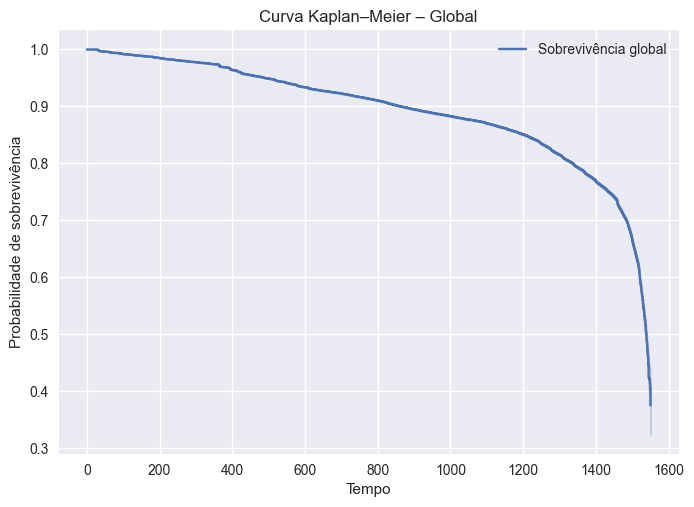

In [111]:
kmf = KaplanMeierFitter()
plt.figure()
kmf.fit(df1["days"], df1["is_churn"], label="Sobrevivência global")
kmf.plot()
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de sobrevivência")
plt.title("Curva Kaplan–Meier – Global")
plt.show()

### 5.2 Período em que a probabilidade de sobrevivência cai para 50%.

In [112]:
kmf.median_survival_time_

1539.0

### 5.3 Períodos em que a probabilidade de sobrevivencia cai para 70%, 50% e 25%.

In [120]:
mediana = kmf.median_survival_time_
print(f"Mediana de sobrevivência: {mediana} unidades de tempo")

quartis = qth_survival_times([0.75, 0.50, 0.25], kmf.survival_function_)
print(quartis)

Mediana de sobrevivência: 1539.0 unidades de tempo
      Sobrevivência global
0.75                1436.0
0.50                1539.0
0.25                   inf


### 5.4 Sobrevivencia por período:

In [119]:
pd.DataFrame(kmf.survival_function_at_times([10,500,800,1000,1300, 1350,1400,1450,1500,1539,1600]))

,Sobrevivência global
10,0.999926
500,0.948897
800,0.910377
1000,0.883111
1300,0.815110
1350,0.792907
1400,0.768350
1450,0.740861
1500,0.664348
1539,0.491822


In [154]:
cities = df1['city'].unique()

resultados = []

for city in cities:
    df_city = df1[df1["city"] == city]
    kmf.fit(df_city["days"], df_city["is_churn"])
    
    mediana = kmf.median_survival_time_
    resultados.append({"City": city, "Median_Survival": mediana})

df_medianas = pd.DataFrame(resultados).sort_values(by="Median_Survival", ascending=True).head(10)
df_medianas

,City,Median_Survival
18,16.0,1495.0
11,3.0,1502.0
13,8.0,1520.0
5,12.0,1522.0
14,7.0,1522.0
12,21.0,1522.0
16,10.0,1526.0
6,6.0,1526.0
8,4.0,1528.0
0,5.0,1530.0


In [155]:
payment_ = df1['payment_method'].unique()

resultados = []

for payment in payment_:
    df_payment = df1[df1["payment_method"] == payment]
    kmf.fit(df_payment["days"], df_payment["is_churn"])
    
    mediana = kmf.median_survival_time_
    resultados.append({"Payment method": payment, "Median_Survival": mediana})

df_medianas = pd.DataFrame(resultados).sort_values(by="Median_Survival", ascending=True).head(10)
df_medianas

,Payment method,Median_Survival
25,25.0,38.0
20,17.0,118.0
9,20.0,404.0
24,8.0,414.0
13,13.0,532.0
6,22.0,805.0
17,12.0,819.0
4,32.0,838.0
30,3.0,943.0
18,26.0,986.0


In [158]:
registered_via_ = df1['registered_via'].unique()

resultados = []

for registered_via in registered_via_:
    df_registered_via = df1[df1["registered_via"] == registered_via]
    kmf.fit(df_registered_via["days"], df_registered_via["is_churn"])
    
    mediana = kmf.median_survival_time_
    resultados.append({"Registered_via": registered_via, "Median_Survival": mediana})

df_medianas = pd.DataFrame(resultados).sort_values(by="Median_Survival", ascending=True).head(10)
df_medianas

,Registered_via,Median_Survival
3,4.0,506.0
2,9.0,1518.0
0,3.0,1526.0
1,7.0,inf
4,13.0,inf


# 6.0 Analysis of the influence of covariates on churn

### 6.1 Data preparation

### 6.1.1 Rescaling

In [20]:
cols_to_encode = ['city', 'payment_method']
encoder_freq_a = CountEncoder(cols=cols_to_encode, normalize=True)


mm_reg_a = RobustScaler()


rs_plan_price_a = RobustScaler()


scaler_pay_a = MinMaxScaler()
scaler_ac_a = MinMaxScaler()

In [21]:
df1["plan_list_price"]=rs_plan_price_a.fit_transform(df1[["plan_list_price"]])



df1["registered_via"]=mm_reg_a.fit_transform(df1[["registered_via"]])


df1["payments_pan_days"]= scaler_pay_a.fit_transform(df1[["payments_pan_days"]])
df1["actual_paid"]=scaler_ac_a.fit_transform(df1[["actual_paid"]])

df1=encoder_freq_a.fit_transform(df1)

### 6.2 Analysis of the impact of covariates

In [34]:
cxphfit = CoxPHFitter(penalizer=0.01).fit(df1.drop(columns="msno"),duration_col="days",event_col="is_churn")

In [35]:
cxphfit.print_summary()

<lifelines.CoxPHFitter: fitted with 583743 total observations, 529472 right-censored observations>
             duration col = 'days'
                event col = 'is_churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 583743
number of events observed = 54271
   partial log-likelihood = -632661.84
         time fit was run = 2026-01-16 20:44:45 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
city               0.37      1.44      0.02            0.34            0.40                1.40                1.49
registered_via     0.02      1.02      0.00            0.02            0.03                1.02                1.03
payment_method    -0.97      0.38      0.02           -1.02           -0.93                0.36                0.39
payments_pan_days  1.14      3.12      0.08            0.99            1.29                2.68                3.62
plan_list_price    0.00      1.00      0.00           -0.00            0.01                1.00                1.01
is_auto_renew     -1.73      0.18      0.01           -1.75           -1.71                0.17                0.18
actual_paid       -0.37      0.69      0.08           -0.53           -0.21                0.59                0.81

                   cmp to       z      p  -log2(p)
covariate                                         
city                 0.00   22.69 <0.005    376.14
registered_via       0.00   12.85 <0.005    123.19
payment_method       0.00  -43.32 <0.005       inf
payments_pan_days    0.00   14.82 <0.005    162.56
plan_list_price      0.00    0.63   0.53      0.91
is_auto_renew        0.00 -162.86 <0.005       inf
actual_paid          0.00   -4.55 <0.005     17.51
---
Concordance = 0.78
Partial AIC = 1265337.67
log-likelihood ratio test = 59969.76 on 7 df
-log2(p) of ll-ratio test = inf

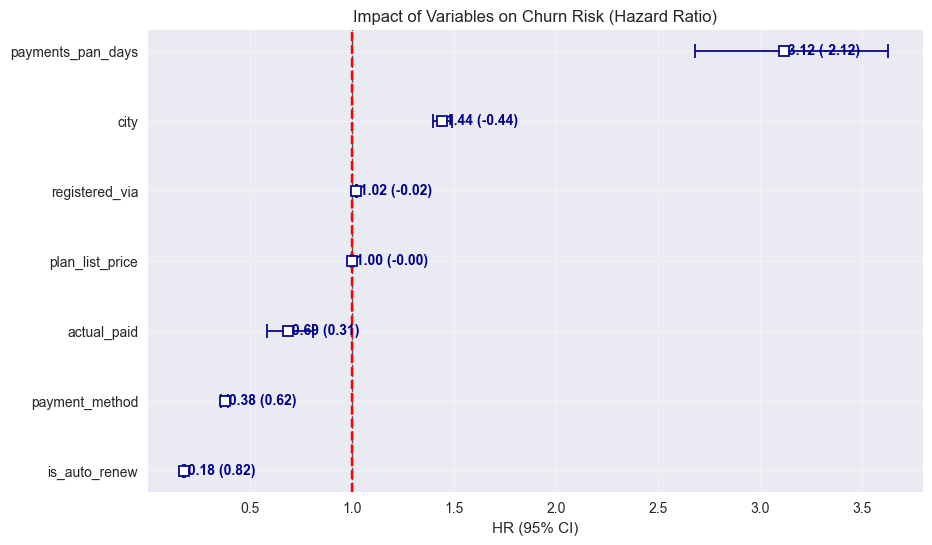

In [ ]:
plt.figure(figsize=(10, 6))
ax = cxphfit.plot(
    hazard_ratios=True,
    c='darkblue',      
    capsize=5
)


summary = cxphfit.summary
hr_values = summary['exp(coef)'].sort_values()


for i, (var_name, hr) in enumerate(hr_values.items()):
    ax.text(
        hr,           
        i,            
        f' {hr:.2f} ({1-hr:.2f})', 
        va='center',  
        ha='left',    
        fontsize=10,
        fontweight='bold',
        color='darkblue'
    )


plt.title("Impact of Variables on Churn Risk (Hazard Ratio)")
plt.axvline(1, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

### 6.3 Schoenfeld Residuals Test

**Schoenfeld Residuals Test: Use statistical tests and graphs to check if the residuals are randomly distributed over time.**

In [81]:
results = cxphfit.check_assumptions(df1.drop(columns="msno"),p_value_threshold=0.05, show_plots=False)
print(results)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 583743 total observations, 529472 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
actual_paid       km             18.34 <0.005     15.72
                  rank           33.25 <0.005     26.88
city              km            379.30 <0.005    278.22
                  rank          728.12 <0.005    530.31
is_auto_renew     km             38.68 <0.005     30.90
                  rank           28.43 <0.005     23.30
payment_method    km           1165.20 <0.005    845.93
                  rank         1679.84 <0.005       inf
payments_pan_days km              1.15   0.28      1.82
                  rank            2.13   0.14      2.79
plan_list_price   km              4.23   0.04      4.66
                  rank            9.44 <0.005      8.88
registered_via    km            120.32 <0.005     90.58
                  rank          303.60 <0.005    223.45



1. Variable 'city' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'city' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'city' using pd.cut, and then specify it in `strata=['city',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'registered_via' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['registered_via', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'payment_method' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variabl

The Cox model was used for exploratory analysis of the effects of the covariates.
The proportional hazards test indicated a violation for two variables, namely payments_pan_days and plan_list_price, which is expected in churn problems. For predictive purposes, we used more flexible survival models.

### 6.2 Analysis of the covariates that accelerate churn (AFT)

In [22]:
aft = WeibullAFTFitter()
aft.fit(df1.drop(columns="msno"), duration_col="days", event_col="is_churn")

aft.summary

coef    exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                            
lambda_ actual_paid        2.867324    17.589882  0.460933        1.963912   
        city              -0.291912     0.746834  0.011375       -0.314207   
        is_auto_renew      1.137515     3.119007  0.008266        1.121314   
        payment_method     0.767688     2.154779  0.017400        0.733584   
        payments_pan_days -1.860191     0.155643  0.074168       -2.005557   
        plan_list_price   -0.036373     0.964281  0.011677       -0.059260   
        registered_via    -0.010079     0.989972  0.001116       -0.012267   
        Intercept          7.160454  1287.495056  0.035350        7.091169   
rho_    Intercept          0.440563     1.553582  0.003509        0.433685   

                           coef upper 95%  exp(coef) lower 95%  \
param   covariate                                                
lambda_ actual_paid              3.770736             7.127155   
        city                    -0.269617             0.730368   
        is_auto_renew            1.153715             3.068884   
        payment_method           0.801792             2.082532   
        payments_pan_days       -1.714824             0.134585   
        plan_list_price         -0.013486             0.942462   
        registered_via          -0.007890             0.987808   
        Intercept                7.229739          1201.310864   
rho_    Intercept                0.447441             1.542933   

                           exp(coef) upper 95%  cmp to           z  \
param   covariate                                                    
lambda_ actual_paid                  43.411985     0.0    6.220698   
        city                          0.763672     0.0  -25.661828   
        is_auto_renew                 3.169948     0.0  137.616970   
        payment_method                2.229533     0.0   44.119475   
        payments_pan_days             0.179995     0.0  -25.080824   
        plan_list_price               0.986605     0.0   -3.114833   
        registered_via                0.992141     0.0   -9.027349   
        Intercept                  1379.862256     0.0  202.557522   
rho_    Intercept                     1.564304     0.0  125.545921   

                                       p    -log2(p)  
param   covariate                                     
lambda_ actual_paid         4.949474e-10   30.912006  
        city               3.119929e-145  480.038060  
        is_auto_renew       0.000000e+00         inf  
        payment_method      0.000000e+00         inf  
        payments_pan_days  8.052531e-139  458.738563  
        plan_list_price     1.840492e-03    9.085693  
        registered_via      1.758805e-19   62.302038  
        Intercept           0.000000e+00         inf  
rho_    Intercept           0.000000e+00         inf

In [23]:
check_p = aft.summary["p"]

d_c = pd.DataFrame(check_p).reset_index()

d_c.columns = ['Parametro', 'Covariavel', 'Valor']

d_c['Flag'] = np.where(d_c['Valor'] < 0.05, "Significativo", "Não significativo")

d_c = d_c[['Covariavel', 'Valor', 'Flag']]



In [24]:
d_c

,Covariavel,Valor,Flag
0,actual_paid,4.949474e-10,Significativo
1,city,3.119929e-145,Significativo
2,is_auto_renew,0.000000e+00,Significativo
3,payment_method,0.000000e+00,Significativo
4,payments_pan_days,8.052531e-139,Significativo
5,plan_list_price,1.840492e-03,Significativo
6,registered_via,1.758805e-19,Significativo
7,Intercept,0.000000e+00,Significativo
8,Intercept,0.000000e+00,Significativo


- This is the most important column. It indicates the relationship with the logarithm of time.
    * Positive Coefficient ($> 0$): Means that the variable increases survival time. The customer takes longer to churn (which is good for the business). Negative Coefficient 
    * Negative Coefficient ($< 0$): This means that the variable decreases survival time. Churn happens faster (which is bad).
    * If exp(coef) = 1.20: The variable increases lifespan by 20%.
    * If exp(coef) = 0.80: The variable reduces the lifespan to 80% of the original (that is, Churn comes 20% faster).



* Note 1: The covariates bd, payments_pan_days, plan_list_price, and registered_via speed up the churn time. The others slow it down.
* Note 2: The covariate with the greatest impact on delaying churn is is_auto_renew at 247%.
* Note 3: All covariates showed statistical significance.


# 7.0 Training-Validation-Test Split

In [41]:
df_trans = df_raw[df_raw["days"]>0]

df_trans = df_trans.drop(columns="plan_list_price")

In [42]:
df_trans["year"] = pd.to_datetime(df_trans["date_ini"]).dt.year

In [43]:
df_train_val, df_test_ = train_test_split(
    df_trans,
    test_size=0.1,
    stratify=df_trans['is_churn'], 
    random_state=42
)


df_train_, df_val_ = train_test_split(
    df_train_val,
    test_size=0.1,
    stratify=df_train_val['is_churn'],
    random_state=42
)

print(f"Treino: {df_train_.shape[0]} | Validação: {df_val_.shape[0]} | Teste: {df_test_.shape[0]}")

Treino: 472831 | Validação: 52537 | Teste: 58375


In [44]:
df_train = df_train_.copy()
df_val = df_val_.copy()
df_test = df_test_.copy()

## 7.1 Preparation Data

### 7.1.1 Rescaling

In [45]:
mm_reg = RobustScaler()

scaler_pay = MinMaxScaler()
scaler_ac = MinMaxScaler()

In [ ]:
cols_to_encode = ['city', 'payment_method']
encoder_freq = CountEncoder(cols=cols_to_encode, normalize=True)


df_train["registered_via"]=mm_reg.fit_transform(df_train[["registered_via"]])
with open('models/mm_reg.pkl',"wb") as f:
    pickle.dump(mm_reg,f)

df_train["payments_pan_days"]= scaler_pay.fit_transform(df_train[["payments_pan_days"]])
with open('models/scaler_pay.pkl',"wb") as f:
    pickle.dump(scaler_pay,f)

df_train["actual_paid"]=scaler_ac.fit_transform(df_train[["actual_paid"]])
with open('models/scaler_ac.pkl',"wb") as f:
    pickle.dump(scaler_ac,f)

df_train=encoder_freq.fit_transform(df_train)
with open('models/encoder_freq.pkl',"wb") as f:
    pickle.dump(encoder_freq,f)




df_val["registered_via"]=mm_reg.transform(df_val[["registered_via"]])
df_val["payments_pan_days"]= scaler_pay.transform(df_val[["payments_pan_days"]])
df_val["actual_paid"]=scaler_ac.transform(df_val[["actual_paid"]])
df_val=encoder_freq.transform(df_val)

In [47]:
df_train = df_train.drop(columns="date_fim")
df_val = df_val.drop(columns="date_fim")

## 8.0 Parametric Models Test

Note: Test of parametric models to see which one performs best for the data. These models are the baseline reference for performance.

In [52]:
wf = WeibullFitter()
wf.fit(df_train["days"], event_observed=df_train["is_churn"])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 472831 total observations, 428871 right-censored observations>

In [53]:
wf.summary

,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
lambda_,3472.660687,20.381151,3432.714365,3512.607008,1.0,170.336833,0.0,inf
rho_,1.525847,0.005900,1.514283,1.537412,1.0,89.120773,0.0,inf


In [54]:
rho = wf.rho_

if rho < 1:
    print("Risco decrescente ao longo do tempo")
elif np.isclose(rho, 1, atol=0.05):
    print("Risco aproximadamente constante (Exponencial)")
else:
    print("Risco crescente ao longo do tempo")

Risco crescente ao longo do tempo


In [55]:
lnf = LogNormalFitter()
llf = LogLogisticFitter()

lnf.fit(df_train["days"], event_observed=df_train["is_churn"])
llf.fit(df_train["days"], event_observed=df_train["is_churn"])

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 472831 total observations, 428871 right-censored observations>

In [56]:
dist_comparison = pd.DataFrame({
    "Model": ["Weibull", "Log-normal", "Log-logistic"],
    "LogLik": [
        wf.log_likelihood_,
        lnf.log_likelihood_,
        llf.log_likelihood_
    ],
    "AIC": [
        wf.AIC_,
        lnf.AIC_,
        llf.AIC_
    ],
    "BIC": [
        wf.BIC_,
        lnf.BIC_,
        llf.BIC_
    ]
}).sort_values("AIC")

dist_comparison


,Model,LogLik,AIC,BIC
0,Weibull,-428620.623053,857245.246105,857267.379092
2,Log-logistic,-429223.542789,858451.085578,858473.218565
1,Log-normal,-432073.187185,864150.374370,864172.507357


Among the parametric distributions evaluated, the Weibull model showed the best fit to the time-to-churn data, substantially outperforming the Log-normal and Log-logistic models according to the log-likelihood criteria (higher / less negative is better), AIC (lower is better), and BIC (lower is better).

# 9.0 Cross validation e fine tunning

### 9.1 Weibull AFT

In [57]:
def run_survival_weibull(model, X, y_df):
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    c_indices = []

    for train_idx, val_idx in cv_strategy.split(X, y_df['is_churn']):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_df, y_val_df = y_df.iloc[train_idx], y_df.iloc[val_idx]

        train_data = pd.concat([X_train, y_train_df[['days', 'is_churn']]], axis=1)
        model.fit(train_data, duration_col='days', event_col='is_churn')
            
        risk_preds = -model.predict_expectation(X_val)
        
        c_index = concordance_index_censored(y_val_df['is_churn'].astype(bool), y_val_df['days'], risk_preds)[0]
        c_indices.append(c_index)
        
    return np.mean(c_indices)

In [58]:
def objective_weibull(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 0.5),
        'penalizer': trial.suggest_float('penalizer', 0.0, 0.1)
    }
    model = WeibullAFTFitter(**params)
    
    features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']
    
    c_index = run_survival_weibull(model, df_train[features], df_train[["days","is_churn"]])
    return c_index

In [60]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_wei = optuna.create_study(direction='maximize')
study_wei.optimize(objective_weibull, n_trials=15)

In [61]:
study_wei.best_params

{'alpha': 0.3500906414611292, 'penalizer': 0.02633458205561101}

In [62]:
study_wei.best_value

0.7817166188688423

### 9.2 XGBoost Cox

Note: The Cox model was included for future use in score classification.

In [64]:
def run_survival_xgb(X, y_df, params):
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    c_indices = []

    for train_idx, val_idx in cv_strategy.split(X, y_df['is_churn']):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_df, y_val_df = y_df.iloc[train_idx], y_df.iloc[val_idx]

        y_train_xgb = y_train_df['days'].copy()
        y_train_xgb[y_train_df['is_churn'] == 0] *= -1

        y_val_xgb = y_val_df['days'].copy()
        y_val_xgb[y_val_df['is_churn'] == 0] *= -1

        dtrain = xgb.DMatrix(X_train, label=y_train_xgb)
        
        dval = xgb.DMatrix(X_val)

        model = xgb.train(params, dtrain, num_boost_round=500)

        risk_preds = model.predict(dval)     
       
        c_index = concordance_index_censored(y_val_df['is_churn'].astype(bool), y_val_df['days'], risk_preds)[0]
        
        c_indices.append(c_index)

    return np.mean(c_indices)

In [65]:
def objective_xgb(trial):
    
    params = {
        "objective": "survival:cox",
        "tree_method": "hist", 
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True), # L2
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),   # L1
        "verbosity": 0
    }
    
    features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']
    
    c_index = run_survival_xgb(df_train[features], df_train[["days","is_churn"]], params)
    return c_index

In [66]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

In [67]:
study_xgb.best_params

{'learning_rate': 0.03522381662286463,
 'max_depth': 6,
 'min_child_weight': 5,
 'lambda': 0.0011398225280102486,
 'alpha': 1.1248663202229807}

In [68]:
study_xgb.best_value

0.840285565265457

### 9.3 XGBoost aft

In [ ]:
def run_survival_xgb_aft(X, y_df, params):
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    c_indices = []
    ibs_scores = []

    sigma = params["aft_loss_distribution_scale"]
    
    for train_idx, val_idx in cv_strategy.split(X, y_df['is_churn']):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_df, y_val_df = y_df.iloc[train_idx], y_df.iloc[val_idx]

        x_c = pd.concat([X_train,y_train_df],axis=1)
        x_v = pd.concat([X_val,y_val_df],axis=1)

        y_train_lower, y_train_upper = make_aft_bounds(x_c)
        y_val_lower, y_val_upper = make_aft_bounds(x_v)


        dtrain = xgb.DMatrix(
        X_train,
        label_lower_bound=y_train_lower,
        label_upper_bound=y_train_upper
        )

        dval = xgb.DMatrix(
        X_val,
        label_lower_bound=y_val_lower,
        label_upper_bound=y_val_upper
        )

        model = xgb.train(params, dtrain, num_boost_round=500)

        pred_log_time = model.predict(dval)     

        risk_preds = -pred_log_time

        c_index = concordance_index_censored(y_val_df['is_churn'].astype(bool), y_val_df['days'], risk_preds)[0]
        
        
        c_indices.append(c_index)



        
        min_time = y_val_df['days'].min() + 1
        max_time = y_val_df['days'].max() - 1

        
        times = np.linspace(min_time, max_time, 100)

        def get_survival_probabilities(log_mu_preds, times, sigma=sigma):
            probs = []
            for t in times:
   
                z = (np.log(t + 1e-8) - log_mu_preds) / sigma
                
                
                survival_t = np.exp(-np.exp(z))
                
                probs.append(survival_t)
            return np.array(probs).T

        surv_probs = get_survival_probabilities(pred_log_time, times)

        
        y_train_struct = np.array([(bool(s), t) for s, t in zip(y_train_df['is_churn'], y_train_df['days'])],
                                dtype=[('event', 'bool'), ('time', 'float')])

        y_val_struct = np.array([(bool(s), t) for s, t in zip(y_val_df['is_churn'], y_val_df['days'])],
                                dtype=[('event', 'bool'), ('time', 'float')])

       
        ibs_value = integrated_brier_score(y_train_struct, y_val_struct, surv_probs, times)
        ibs_scores.append(ibs_value)

        

    return np.mean(ibs_scores)

In [ ]:
def objective_xgb_aft(trial):

 

    params = {
        "objective": "survival:aft",
        "tree_method": "hist",
        "aft_loss_distribution":"extreme",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 10.0),
        "aft_loss_distribution_scale": trial.suggest_float("aft_loss_distribution_scale", 0.2, 0.45),
        "eval_metric": "aft-nloglik",
        "verbosity": 0,
    }

    
    
    features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']
    
    ibs = run_survival_xgb_aft(df_train[features], df_train[["days","is_churn"]], params)
    return ibs

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_xgb_aft = optuna.create_study(direction='minimize')
study_xgb_aft.optimize(objective_xgb_aft, n_trials=20)

[I 2026-01-16 12:58:24,213] A new study created in memory with name: no-name-fb9ef78d-5af0-481c-b0f2-442371c58b36
[I 2026-01-16 12:59:28,383] Trial 0 finished with value: 0.10729157695688962 and parameters: {'learning_rate': 0.026458847792181384, 'max_depth': 5, 'min_child_weight': 9.814261980628514, 'subsample': 0.7560894337455564, 'colsample_bytree': 0.6373704503547861, 'gamma': 6.410745677213924, 'reg_alpha': 1.4957436009765812, 'reg_lambda': 7.836521968873329, 'aft_loss_distribution_scale': 0.36926377585555015}. Best is trial 0 with value: 0.10729157695688962.
[I 2026-01-16 13:00:31,952] Trial 1 finished with value: 0.10729157695688962 and parameters: {'learning_rate': 0.025909019592498396, 'max_depth': 5, 'min_child_weight': 30.941032487299662, 'subsample': 0.8529071103150772, 'colsample_bytree': 0.6612093149906765, 'gamma': 2.9088397987475045, 'reg_alpha': 2.033936568844928, 'reg_lambda': 9.739531260374001, 'aft_loss_distribution_scale': 0.3118188905304706}. Best is trial 0 with 

In [ ]:

study_xgb_aft.best_params

{'learning_rate': 0.01722449722190135,
 'max_depth': 6,
 'min_child_weight': 5.442834131609996,
 'subsample': 0.809165073060195,
 'colsample_bytree': 0.7951009041607903,
 'gamma': 1.2190059317958157,
 'reg_alpha': 2.6874763567569824,
 'reg_lambda': 6.1739378229869075,
 'aft_loss_distribution_scale': 0.20149650289568866}

# 10.0 Training-validation

### 10.1. XGBoost

### 10.1.1 Teste-validação XGBoost Cox

In [ ]:
features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']

xgb_params = {'learning_rate': 0.03522381662286463,
 'max_depth': 6,
 'min_child_weight': 5,
 'lambda': 0.0011398225280102486,
 'alpha': 1.1248663202229807,
        "objective": "survival:cox",
        "tree_method": "hist",
	"verbosity":0}


X_train = df_train[features]
X_val = df_val[features]

y_train_xgb = make_y_xgb(df_train, "days", "is_churn")

y_val_xgb = make_y_xgb(df_val, "days", "is_churn")


model_xgb = train_xgb_survival(
        X_train,
        y_train_xgb,
        xgb_params
    )

y_train_surv = make_surv_object(df_train, "days", "is_churn")

y_val_surv = make_surv_object(df_val, "days", "is_churn")


c_index_xgb = metrics(model_xgb,X_val,y_val_surv)

In [74]:
c_index_xgb

0.8333030101507657

### 10.1.2 Teste-validação XGBoost AFT

In [ ]:
features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']
X_train_ = df_train[features]
X_val_ = df_val[features]
  

y_lower_train = df_train['days'].values.astype('float32')
y_upper_train = np.where(df_train['is_churn'] == 1, y_lower_train, np.inf).astype('float32')


dtrain = xgb.DMatrix(
    X_train_, 
    label=y_lower_train, 
    label_lower_bound=y_lower_train, 
    label_upper_bound=y_upper_train
)
dval = xgb.DMatrix(X_val_) 



xgb_params_AFT = {
      "objective": "survival:aft",
        "aft_loss_distribution": "extreme",
        "tree_method": "hist",
        "verbosity": 1,
        'learning_rate': 0.01722449722190135,
 'max_depth': 6,
 'min_child_weight': 5.442834131609996,
 'subsample': 0.809165073060195,
 'colsample_bytree': 0.7951009041607903,
 'gamma': 1.2190059317958157,
 'reg_alpha': 2.6874763567569824,
 'reg_lambda': 6.1739378229869075,
 'aft_loss_distribution_scale': 0.20149650289568866
}

model_xgb_aft_ = xgb.train(xgb_params_AFT, dtrain, num_boost_round=500)

preds = model_xgb_aft_.predict(dval)


y_val_struct = np.array([(bool(s), t) for s, t in zip(df_val['is_churn'], df_val['days'])],
                         dtype=[('event', 'bool'), ('time', 'float')])



c_index_aft = concordance_index_censored(y_val_struct['event'], y_val_struct['time'], -preds)

print(f"C-Index: {c_index_aft[0]:.4f}")

C-Index: 0.8048


In [ ]:
min_time = df_val['days'].min() + 1
max_time = df_val['days'].max() - 1

times = np.linspace(min_time, max_time, 100)

def get_survival_probabilities(log_mu_preds, times, sigma=xgb_params_AFT["aft_loss_distribution_scale"]):
    probs = []
    for t in times:

        z = (np.log(t + 1e-8) - log_mu_preds) / sigma
        
  
        survival_t = np.exp(-np.exp(z))
        
        probs.append(survival_t)
    return np.array(probs).T

surv_probs = get_survival_probabilities(preds, times)


y_train_struct = np.array([(bool(s), t) for s, t in zip(df_train['is_churn'], df_train['days'])],
                           dtype=[('event', 'bool'), ('time', 'float')])

y_val_struct = np.array([(bool(s), t) for s, t in zip(df_val['is_churn'], df_val['days'])],
                         dtype=[('event', 'bool'), ('time', 'float')])


ibs_value = integrated_brier_score(y_train_struct, y_val_struct, surv_probs, times)
print(f"IBS: {ibs_value:.4f}")

IBS: 0.1067


### 10.1.3 Resultado Teste-validação

In [94]:
pd.DataFrame({"aft c_index":[c_index_aft[0]],"aft ibs":[ibs_value],"Cox c_index":[c_index_xgb]})

,aft c_index,aft ibs,Cox c_index
0,0.804808,0.106702,0.833303


# 11. Treino-Teste

In [51]:
df_train_total_ = pd.concat([df_train_, df_val_], axis=0)


df_test_total_ = df_test_.copy()

In [52]:
df_train_total_["registered_via"]=mm_reg.transform(df_train_total_[["registered_via"]])


df_train_total_["payments_pan_days"]= scaler_pay.transform(df_train_total_[["payments_pan_days"]])
df_train_total_["actual_paid"]=scaler_ac.transform(df_train_total_[["actual_paid"]])

df_train_total_=encoder_freq.transform(df_train_total_)



df_test_total_["registered_via"]=mm_reg.transform(df_test_total_[["registered_via"]])

df_test_total_["payments_pan_days"]= scaler_pay.transform(df_test_total_[["payments_pan_days"]])
df_test_total_["actual_paid"]=scaler_ac.transform(df_test_total_[["actual_paid"]])

df_test_total_=encoder_freq.transform(df_test_total_)

In [53]:
df_train_total_ = df_train_total_.drop(columns="date_fim")
df_test_total_ = df_test_total_.drop(columns="date_fim")

In [ ]:
features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']

xgb_params = {'learning_rate': 0.03522381662286463,
 'max_depth': 6,
 'min_child_weight': 5,
 'lambda': 0.0011398225280102486,
 'alpha': 1.1248663202229807,
        "objective": "survival:cox",
        "tree_method": "hist",
	"verbosity":0}


X_train = df_train_total_[features]
X_val = df_test_total_[features]

y_train_xgb = make_y_xgb(df_train_total_, "days", "is_churn")

y_val_xgb = make_y_xgb(df_test_total_, "days", "is_churn")


model_xgb_0 = train_xgb_survival(
        X_train,
        y_train_xgb,
        xgb_params
    )

y_train_surv = make_surv_object(df_train_total_, "days", "is_churn")

y_val_surv = make_surv_object(df_test_total_, "days", "is_churn")


c_index_xgb = metrics(model_xgb_0,X_val,y_val_surv)
print(c_index_xgb)

0.8421283325934881


In [58]:
features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']
X_train_ = df_train_total_[features]
X_val_ = df_test_total_[features]
  

y_lower_train = df_train_total_['days'].values.astype('float32')
y_upper_train = np.where(df_train_total_['is_churn'] == 1, y_lower_train, np.inf).astype('float32')


dtrain = xgb.DMatrix(
    X_train_, 
    label=y_lower_train, 
    label_lower_bound=y_lower_train, 
    label_upper_bound=y_upper_train
)
dval = xgb.DMatrix(X_val_) 



xgb_params_AFT = {
      "objective": "survival:aft",
        "aft_loss_distribution": "extreme",
        "tree_method": "hist",
        "verbosity": 1,
        'learning_rate': 0.01722449722190135,
 'max_depth': 6,
 'min_child_weight': 5.442834131609996,
 'subsample': 0.809165073060195,
 'colsample_bytree': 0.7951009041607903,
 'gamma': 1.2190059317958157,
 'reg_alpha': 2.6874763567569824,
 'reg_lambda': 6.1739378229869075,
 'aft_loss_distribution_scale': 0.20149650289568866
}

model_xgb_aft_ = xgb.train(xgb_params_AFT, dtrain, num_boost_round=500)

preds = model_xgb_aft_.predict(dval)


y_val_struct = np.array([(bool(s), t) for s, t in zip(df_test_total_['is_churn'], df_test_total_['days'])],
                         dtype=[('event', 'bool'), ('time', 'float')])



c_index_aft = concordance_index_censored(y_val_struct['event'], y_val_struct['time'], -preds)

print(f"C-Index: {c_index_aft[0]:.4f}")

C-Index: 0.8100


In [59]:
min_time = df_test_total_['days'].min() + 1
max_time = df_test_total_['days'].max() - 1

times = np.linspace(min_time, max_time, 100)

def get_survival_probabilities(log_mu_preds, times, sigma=xgb_params_AFT["aft_loss_distribution_scale"]):
    probs = []
    for t in times:

        z = (np.log(t + 1e-8) - log_mu_preds) / sigma
        
  
        survival_t = np.exp(-np.exp(z))
        
        probs.append(survival_t)
    return np.array(probs).T

surv_probs = get_survival_probabilities(preds, times)


y_train_struct = np.array([(bool(s), t) for s, t in zip(df_train_total_['is_churn'], df_train_total_['days'])],
                           dtype=[('event', 'bool'), ('time', 'float')])

y_val_struct = np.array([(bool(s), t) for s, t in zip(df_test_total_['is_churn'], df_test_total_['days'])],
                         dtype=[('event', 'bool'), ('time', 'float')])


ibs_value = integrated_brier_score(y_train_struct, y_val_struct, surv_probs, times)
print(f"IBS: {ibs_value:.4f}")

IBS: 0.1072


# 12. Final model

### 12.1.1 Training and test split

In [60]:
df_train_total = pd.concat([df_train_, df_val_], axis=0)
df_train_total = pd.concat([df_train_total, df_test_], axis=0)


df_test_total = df_test_.copy()

In [61]:
df_train_total["registered_via"]=mm_reg.transform(df_train_total[["registered_via"]])


df_train_total["payments_pan_days"]= scaler_pay.transform(df_train_total[["payments_pan_days"]])
df_train_total["actual_paid"]=scaler_ac.transform(df_train_total[["actual_paid"]])

df_train_total=encoder_freq.transform(df_train_total)



df_test_total["registered_via"]=mm_reg.transform(df_test_total[["registered_via"]])

df_test_total["payments_pan_days"]= scaler_pay.transform(df_test_total[["payments_pan_days"]])
df_test_total["actual_paid"]=scaler_ac.transform(df_test_total[["actual_paid"]])

df_test_total=encoder_freq.transform(df_test_total)

In [62]:
df_train_total = df_train_total.drop(columns="date_fim")
df_test_total = df_test_total.drop(columns="date_fim")

### 11.1.2 Churn Risk Ranking

In [ ]:
features = ['city', 'registered_via',
       'payment_method', 'payments_pan_days', 'is_auto_renew', 'actual_paid']

xgb_params_ = {'learning_rate': 0.03522381662286463,
 'max_depth': 6,
 'min_child_weight': 5,
 'lambda': 0.0011398225280102486,
 'alpha': 1.1248663202229807,
        "objective": "survival:cox",
        "tree_method": "hist",
	"verbosity":0}

model_xgb_ = xgb.XGBRegressor(**xgb_params_)

X_train = df_train_total[features]
X_val = df_test_total[features]

y_train_xgb = make_y_xgb(df_train_total, "days", "is_churn")





model_xgb_.fit(
    X_train,
    y_train_xgb,
    verbose=False
)

with open('models/model_xgb.pkl',"wb") as f:
    pickle.dump(model_xgb_,f)

risk_score = model_xgb_.predict(X_val)

df_risk = X_val.copy()
df_risk["date_ini"] = df_test_total["date_ini"].copy()


df_risk["risk_score"] = risk_score
df_risk["msno"] = df_test_total["msno"]

df_risk = df_risk.sort_values("risk_score", ascending=False)

df_risk["risk_percentile"] = (
    df_risk["risk_score"]
    .rank(pct=True)
)

df_risk["risk_group"] = pd.cut(
    df_risk["risk_percentile"],
    bins=[0, 0.8,0.85, 0.9, 0.95, 0.99, 1.0],
    labels=["baixo", "medio", "medio-alto","alto", "muito alto", "critico"]
)

In [64]:
df_group_risk = pd.DataFrame(df_risk["risk_group"].value_counts())
df_group_risk["percent"] = pd.DataFrame(df_risk["risk_group"].value_counts(normalize=True)*100)
df_group_risk

,count,percent
risk_group,,
baixo,46700,80.000000
alto,3068,5.255675
medio,2900,4.967880
medio-alto,2765,4.736617
muito alto,2362,4.046253
critico,580,0.993576


### 11.2.1 Time to churn

In [65]:
df_risk_test = df_risk.copy()

In [ ]:
X_train_aft = df_train_total[features]
X_val_aft = df_risk_test[features]
  


y_lower_train = df_train_total['days'].values.astype('float32')
T_max = y_lower_train.max()
y_upper_train = np.where(df_train_total['is_churn'] == 1, y_lower_train, np.inf).astype('float32')


dtrain = xgb.DMatrix(
    X_train_aft, 
    label_lower_bound=y_lower_train, 
    label_upper_bound=y_upper_train
)



dval = xgb.DMatrix(X_val_aft)

xgb_params_AFT = {
      "objective": "survival:aft",
        "aft_loss_distribution": "extreme",
        "tree_method": "hist",
        "verbosity": 1,
        'learning_rate': 0.01722449722190135,
 'max_depth': 6,
 'min_child_weight': 5.442834131609996,
 'subsample': 0.809165073060195,
 'colsample_bytree': 0.7951009041607903,
 'gamma': 1.2190059317958157,
 'reg_alpha': 2.6874763567569824,
 'reg_lambda': 6.1739378229869075,
 'aft_loss_distribution_scale': 0.20149650289568866
}




model_xgb_aft_ = xgb.train(xgb_params_AFT, dtrain, num_boost_round=500)

with open('models/model_xgb_aft.pkl',"wb") as f:
    pickle.dump(model_xgb_aft_,f)

preds_final = model_xgb_aft_.predict(dval)

df_risk_test["expected_days_to_churn"] = preds_final

df_risk_test["expected_churn_date"] = (
    df_risk_test["date_ini"] +
    pd.to_timedelta(df_risk_test["expected_days_to_churn"], unit="D")
)

df_risk_test["pred"] = preds_final

df_risk_test["expected_churn_date"] = pd.to_datetime(df_risk_test["expected_churn_date"]).dt.normalize()

data_ref = df_risk_test["date_ini"].max()+pd.Timedelta(days=1)

df_risk_test['priority_score'] = df_risk_test['actual_paid'] / (df_risk_test['expected_days_to_churn'] + 1)

# 13. Interpretation of variables

In [ ]:
explainer = shap.TreeExplainer(model_xgb_aft_)


shap_values = explainer.shap_values(X_val_aft)

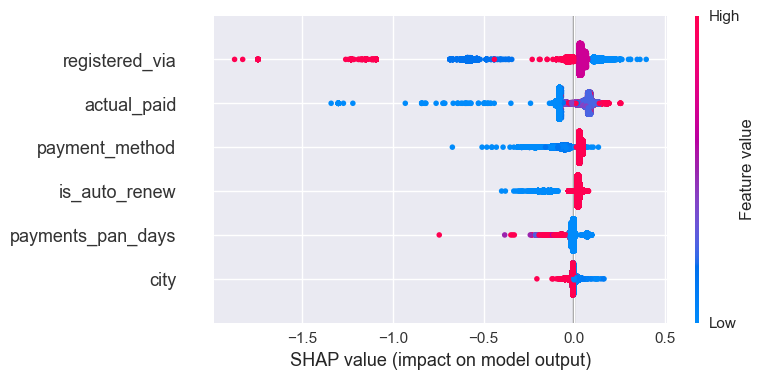

In [ ]:
shap.summary_plot(shap_values, X_val_aft)

1.0. Y-Axis (Variables): They are ordered from the most important (top) to the least important.

2.0. X-Axis (SHAP Value):

- Positive (> 0): The variable is increasing the lifetime (Delaying Churn). The customer stays longer.

- Negative (< 0): The variable is decreasing the lifetime (Accelerating Churn). The risk increases.

3.0. Colors (Variable Value):

- Red: High values of the variable.

- Blue: Low values of the variable.

Red points on the negative side: "High actual_paid (red) decreases the lifetime (negative), that is, accelerates churn."

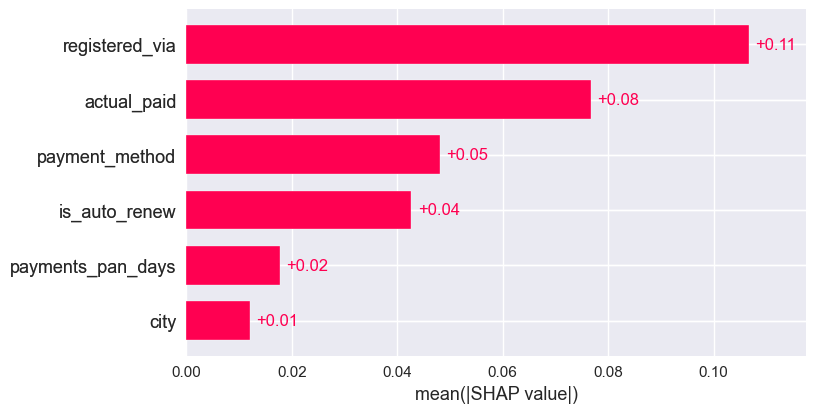

In [140]:
shap_exp = shap.Explanation(
    values=shap_values, 
    data=X_val_aft, 
    feature_names=X_val_aft.columns
)
shap.plots.bar(shap_exp)

Note: As variaveis mais importantes são a registered_via, is_auto_renew e payment_method. As features que tem um impacto médio são o actual_paid e payments_pan_days.

### 13.0 Impact on churn acceleration

In [141]:
mean_shap = shap_values.mean(axis=0)

global_effect = pd.DataFrame({
    "feature": X_val.columns,
    "mean_shap_log_time": mean_shap,
    "time_multiplier": np.exp(mean_shap),
    "percent_change_time": (np.exp(mean_shap) - 1) * 100,
    "The greater": 1/np.exp(mean_shap)
}).sort_values("time_multiplier")

global_effect

,feature,mean_shap_log_time,time_multiplier,percent_change_time,The greater
1,registered_via,-0.019910,0.980287,-1.971340,1.020110
3,payments_pan_days,-0.007650,0.992379,-0.762093,1.007679
2,payment_method,-0.003248,0.996757,-0.324255,1.003253
0,city,-0.002455,0.997548,-0.245178,1.002458
4,is_auto_renew,0.001029,1.001029,0.102949,0.998972
5,actual_paid,0.002793,1.002797,0.279665,0.997211


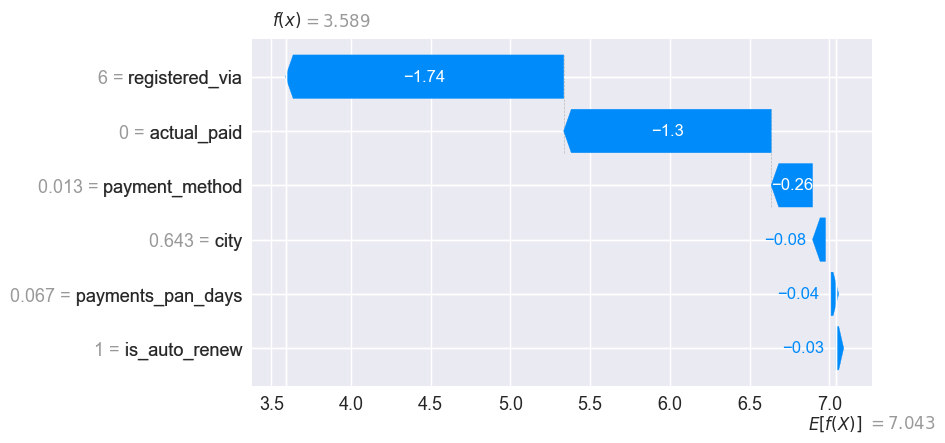

In [142]:
shap.plots.waterfall(explainer(X_val_aft)[0])

This chart explains why a specific customer received a particular risk score.

- $E[f(X)]$ (Base Value): It is the average log-time of all customers. It is the starting point.
- $f(x)$: It is the final prediction for this specific customer.
    * Red Bars: Variables that increase the log-time (make the customer last longer).
    * Blue Bars: Variables that decrease the log-time (make the customer leave faster).

# 13. Loss simulation

In [148]:
df_simulation = df_risk_test.copy()

In [ ]:
df_simulation_final = df_simulation.copy()

for col, series_mapping in encoder_freq.mapping.items():
    # 1. Criamos o dicionário invertido: {Frequência: Nome_Original}
 
    inv_map = {round(v, 10): k for k, v in series_mapping.items()}
    
    # 2. Criamos o nome da nova coluna
    new_col_name = f"{col}_reverted"
    
    # 3. Aplicamos o mapeamento na coluna arredondada

    df_simulation_final[new_col_name] = df_simulation_final[col].round(10).map(inv_map)


--- Primeiras 40 linhas da Simulação Revertida ---
            city  city_reverted  payment_method  payment_method_reverted
934910  0.642940            1.0        0.012791                     30.0
285779  0.642940            1.0        0.012791                     30.0
807160  0.642940            1.0        0.012791                     30.0
325576  0.642940            1.0        0.012791                     30.0
245818  0.642940            1.0        0.012791                     30.0
661531  0.642940            1.0        0.012791                     30.0
12706   0.642940            1.0        0.012791                     30.0
19789   0.642940            1.0        0.012791                     30.0
28848   0.642940            1.0        0.012791                     30.0
60360   0.076006           13.0        0.012791                     30.0
299008  0.642940            1.0        0.012791                     30.0
596183  0.642940            1.0        0.012791                     30.0


In [156]:
df_simulation_final = df_simulation_final.drop(columns=["city","payment_method"])
df_simulation_final = df_simulation_final.rename(columns={"city_reverted":"city","payment_method_reverted":"payment_method"})
df_simulation_final

,registered_via,payments_pan_days,is_auto_renew,actual_paid,date_ini,risk_score,msno,risk_percentile,risk_group,expected_days_to_churn,expected_churn_date,pred,days_to_churn,priority_score,city,payment_method
934910,6.0,0.066667,1.0,0.0000,2017-02-11,2900.791016,SmTMND8KjfWhHRu7dw7RPlQ7nCn7m+00hcYMzUFoE4o=,0.999760,critico,36.203590,2017-03-19,36.203590,18,0.000000,1.0,30.0
285779,6.0,0.066667,1.0,0.0000,2017-02-01,2900.791016,jHjaqfe+Ig/ZKUSd8F44YYUTE5mGuWd+7B/sueD9jwI=,0.999760,critico,36.203590,2017-03-09,36.203590,8,0.000000,1.0,30.0
807160,6.0,0.066667,1.0,0.0000,2017-02-19,2900.791016,iNPzXjCuZHroDDbwkkPiOvV5bgjGqro6vZmypo7G3UQ=,0.999760,critico,36.203590,2017-03-27,36.203590,26,0.000000,1.0,30.0
325576,6.0,0.066667,1.0,0.0000,2017-02-22,2900.791016,FS5G6K7lBSbL7NEQkD2AQo6qxw7XcXHNzTpaDz1g+6c=,0.999760,critico,36.203590,2017-03-30,36.203590,29,0.000000,1.0,30.0
245818,6.0,0.066667,1.0,0.0000,2017-02-26,2900.791016,YXiegOlyuObEVzgWk7czGiaRii+cGg+PJl9fP3Eq080=,0.999760,critico,36.203590,2017-04-03,36.203590,33,0.000000,1.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509142,-4.0,0.068889,1.0,0.0745,2014-11-20,0.138533,t3VbhIxoEdkz2WJX4u7nr7sroq0aDjCLIX8LdEQs7o4=,0.000822,baixo,1511.127686,2019-01-09,1511.127686,679,0.000110,13.0,37.0
300542,-4.0,0.068889,1.0,0.0745,2013-06-28,0.138533,pPj9pDQHMFEuMX6tXhnltwL62i0Rl7f3mPanwNx+asM=,0.000822,baixo,1511.127686,2017-08-17,1511.127686,169,0.000438,13.0,37.0
765233,-4.0,0.068889,1.0,0.0745,2014-03-26,0.138533,q7CoLfIN2FpurBZWOKrDpszncFE0ghtMzOtKDQdqAg0=,0.000822,baixo,1511.127686,2018-05-15,1511.127686,440,0.000169,13.0,37.0
614802,-4.0,0.068889,1.0,0.0745,2013-06-06,0.138533,L4I5IIRGEA2hYPG3W3kBh4gu+auto4Csyq157ZpSPZY=,0.000822,baixo,1511.127686,2017-07-26,1511.127686,147,0.000503,13.0,37.0


In [157]:
df_simulation_final["registered_via"]=mm_reg.inverse_transform(df_simulation_final[["registered_via"]])
df_simulation_final["payments_pan_days"]= scaler_pay.inverse_transform(df_simulation_final[["payments_pan_days"]])
df_simulation_final["actual_paid"]=scaler_ac.inverse_transform(df_simulation_final[["actual_paid"]])

In [158]:
df_simulation_final.head()

,registered_via,payments_pan_days,is_auto_renew,actual_paid,date_ini,risk_score,msno,risk_percentile,risk_group,expected_days_to_churn,expected_churn_date,pred,days_to_churn,priority_score,city,payment_method
934910,13.0,30.0,1.0,0.0,2017-02-11,2900.791016,SmTMND8KjfWhHRu7dw7RPlQ7nCn7m+00hcYMzUFoE4o=,0.99976,critico,36.20359,2017-03-19,36.20359,18,0.0,1.0,30.0
285779,13.0,30.0,1.0,0.0,2017-02-01,2900.791016,jHjaqfe+Ig/ZKUSd8F44YYUTE5mGuWd+7B/sueD9jwI=,0.99976,critico,36.20359,2017-03-09,36.20359,8,0.0,1.0,30.0
807160,13.0,30.0,1.0,0.0,2017-02-19,2900.791016,iNPzXjCuZHroDDbwkkPiOvV5bgjGqro6vZmypo7G3UQ=,0.99976,critico,36.20359,2017-03-27,36.20359,26,0.0,1.0,30.0
325576,13.0,30.0,1.0,0.0,2017-02-22,2900.791016,FS5G6K7lBSbL7NEQkD2AQo6qxw7XcXHNzTpaDz1g+6c=,0.99976,critico,36.20359,2017-03-30,36.20359,29,0.0,1.0,30.0
245818,13.0,30.0,1.0,0.0,2017-02-26,2900.791016,YXiegOlyuObEVzgWk7czGiaRii+cGg+PJl9fP3Eq080=,0.99976,critico,36.20359,2017-04-03,36.20359,33,0.0,1.0,30.0


In [ ]:
df_simulation_final = df_simulation_final.sort_values(by='priority_score', ascending=False).reset_index(drop=True)

In [163]:
df_retorn = simular_reversao(df_simulation[df_simulation["risk_group"].isin(["critico","muito alto"])], list(range(0,105,5)))

In [164]:
df_retorn

,Cenário (Redução Churn %),Clientes Atendidos,Valor Recuperado,% do Valor Total Salvo,Rec_em_3_meses,Rec_em_6_meses,Rec_em_12_meses,Rec_em_24_meses
0,0%,0,0.0000,0.000000,0.0000,0.000,0.000,0.000
1,5%,147,80.8960,20.567660,242.6880,485.376,970.752,1941.504
2,10%,294,131.1815,33.352656,393.5445,787.089,1574.178,3148.356
3,15%,442,160.5380,40.816493,481.6140,963.228,1926.456,3852.912
4,20%,589,178.9440,45.496184,536.8320,1073.664,2147.328,4294.656
5,25%,737,196.6745,50.004132,590.0235,1180.047,2360.094,4720.188
6,30%,884,213.4025,54.257195,640.2075,1280.415,2560.830,5121.660
7,35%,1031,226.2255,57.517419,678.6765,1357.353,2714.706,5429.412
8,40%,1179,238.6130,60.666918,715.8390,1431.678,2863.356,5726.712
9,45%,1326,250.9895,63.813621,752.9685,1505.937,3011.874,6023.748
